# MileStone 2: Data Collection and Description

We will explore two different set of datasets:

* GBD dataset, which will contain the measures for each mental disease per geographic area we can find
* We will explore the five continents - Europe, Asia, America, Africa, Oceania
* We also choose to explore the 3 representative countries from 3 largest continents - Russia, China, France, Australia and United States

This project aims to understand the effect of mental disorders on people's life by measuring their impact and the percentage of people attained by the mental disorders.

We first clean the data by selecting the columns of the data set we want to read, then we will explore each dataset separately.


## The GBD Dataset

We made several queries using the [GBD query tool](http://ghdx.healthdata.org/gbd-results-tool), selecting all mental disorders for all ages in these countries. These queries return us the necessary csv files. We after cleaning all unnecessary datas, we are left with 3 csvs with all the essential datas we need. To save time, we will solely work with these csv (instead of the original 5GB dataset).

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum
import numpy as np
import json
import folium
from branca.colormap import LinearColormap, StepColormap
from matplotlib.legend import Legend
import itertools

In [4]:
# define constant numbers
ONE_MILLION = 1000000

In [5]:
data_folder = "./data/"
reading_folder = "./data/Last_data/"
saving_folder = "./data/Last_data/"
file_list = [i for i in sorted(os.listdir(reading_folder)) if 'IHME-GBD' in i]

In [42]:
pdfs = []
for file in file_list:
    print("Reading {} ...".format(file))
    pdfs.append(pd.read_csv(reading_folder + file))

Reading IHME-GBD_2017_DATA-1a98c9fa-1.csv ...
Reading IHME-GBD_2017_DATA-1a98c9fa-2.csv ...
Reading IHME-GBD_2017_DATA-1a98c9fa-3.csv ...


### Data Cleaning

We decided to split the dataset according to different measures - Prevalence, Deaths and DALY. We then save them into separately.

In [43]:
# Merge into one huge data matrix
pd_all = pd.concat(pdfs).reset_index(drop=True)
pd_all.shape

(1238160, 10)

Here is what the data looks like: 

In [44]:
pd_all.head()

,measure,location,sex,age,cause,metric,year,val,upper,lower
0,Prevalence,France,Male,1 to 4,Depressive disorders,Number,1990,0.0,0.0,0.0
1,Prevalence,France,Female,1 to 4,Depressive disorders,Number,1990,0.0,0.0,0.0
2,Prevalence,France,Both,1 to 4,Depressive disorders,Number,1990,0.0,0.0,0.0
3,Prevalence,France,Male,1 to 4,Depressive disorders,Rate,1990,0.0,0.0,0.0
4,Prevalence,France,Female,1 to 4,Depressive disorders,Rate,1990,0.0,0.0,0.0


In [45]:
# Get all measure names
measure_names = pd_all.measure.unique()
# Group by and get all groups
groups_by = pd_all.groupby('measure')
measure_groups = dict.fromkeys(measure_names)
for measure in measure_names:
    measure_groups[measure] = groups_by.get_group(measure)
    
# Save the groups in csv
for measure in measure_names:
    filename = saving_folder+measure+".csv"
    print("Saving {} to {}".format(measure, filename))
    measure_groups[measure].to_csv(filename, compression="zip")

Saving Prevalence to ./data/Last_data/Prevalence.csv
Saving DALYs (Disability-Adjusted Life Years) to ./data/Last_data/DALYs (Disability-Adjusted Life Years).csv
Saving Deaths to ./data/Last_data/Deaths.csv


### Exploring by DALY

DALYs equal the sum of years of life lost (YLLs) and years lived with disability (YLDs). DALYs allow us to estimate the total number of years lost due to specific causes and risk factors at the country, regional, and global levels.
One DALY can be thought of as one lost year of "healthy" life. The sum of these DALYs across the population, or the burden of disease, can be thought of as a measurement of the gap between current health status and an ideal health situation where the entire population lives to an advanced age, free of disease and disability.

In [6]:
DALY = pd.read_csv(saving_folder + "DALYs (Disability-Adjusted Life Years).csv", index_col=0, low_memory=False).dropna()
DALY.year = DALY.year.astype(int)
DALY.head()

,measure,location,sex,age,cause,metric,year,val,upper,lower
PK,,,,,,,,,,
24576,DALYs (Disability-Adjusted Life Years),Oceania,Male,1 to 4,Depressive disorders,Number,1990,0.971585,1.930318,0.424445
24577,DALYs (Disability-Adjusted Life Years),Oceania,Female,1 to 4,Depressive disorders,Number,1990,0.986340,1.969994,0.433837
24578,DALYs (Disability-Adjusted Life Years),Oceania,Both,1 to 4,Depressive disorders,Number,1990,1.957925,3.873068,0.861491
24579,DALYs (Disability-Adjusted Life Years),Oceania,Male,1 to 4,Depressive disorders,Rate,1990,0.243385,0.483551,0.106325
24580,DALYs (Disability-Adjusted Life Years),Oceania,Female,1 to 4,Depressive disorders,Rate,1990,0.264145,0.527570,0.116183


In [7]:
# Rename the column 5-9 for easier ordering later
DALY.age = DALY.age.replace({'5 to 9':'05 to 09', '1 to 4':'01 to 04'})
# These are the ages we will look at
DALY.age.unique()

array(['01 to 04', '05 to 09', '10 to 14', '15 to 19', '20 to 24',
       '25 to 29', '30 to 34', '35 to 39', '40 to 44', '45 to 49',
       '50 to 54', '55 to 59', '60 to 64', '65 to 69', '70 to 74',
       '75 to 79', 'All Ages', '80 to 84', '85 to 89', '90 to 94',
       '95 plus'], dtype=object)

In [8]:
# These are the locations we will look at
DALY.location.unique()

array(['Oceania', 'Global', 'China', 'Russian Federation', 'Australia',
       'United States', 'America', 'Africa', 'Asia', 'France', 'Europe'],
      dtype=object)

In [9]:
# These are the mental illness we will look at
DALY.cause.unique()

array(['Depressive disorders', 'Major depressive disorder', 'Dysthymia',
       'Bipolar disorder', 'Anxiety disorders', 'Eating disorders',
       'Anorexia nervosa', 'Bulimia nervosa', 'Autism spectrum disorders',
       'Attention-deficit/hyperactivity disorder', 'Conduct disorder',
       'Idiopathic developmental intellectual disability',
       'Other mental disorders', 'Mental disorders', 'Schizophrenia'],
      dtype=object)

When we take a look at causes, we realize that some of these diseases overlap. For example, mental disorders is a header cause that is essentially just a grouped aggregation of other causes. In total, based on the query we used to obtain this data, there are four levels of causes. We will only use the first two levels because the last level is extremely specific and out of the scope of this project. We therefore create two lists of levels. If we want to look at mental disorders prevalence as a whole, we can filter by cause_name in level_1. If we want to group by more specific cause_types or dig deeper into a specific cause, we can filter by cause_name in level_2. Finally, on the fourth level, depression and eating disorders each have distinct sub-mental disorders.

In [30]:
# For when splitting the dataset per measure
class Measure(Enum):
    NUMBER = 1
    RATE = 2
    PERCENT = 3

def get_data_per_locations(locations, dataset, measure):
    """Returns a dictionary per country for the dataset, the measureand the locations selected"""    
    if measure == Measure.NUMBER:
        data = dataset.loc[dataset.metric == 'Number']
    elif measure == Measure.RATE:
        data = dataset.loc[dataset.metric == 'Rate']
    else:
        raise Exception('Error: Unknown measure {} !'.format(measure))
    
    if locations == None:
        return data
    
    data_per_country = dict.fromkeys(locations)
    for location in locations:
        data_per_country[location] = data[(data.location == location)].sort_values(by='year')
    
    return data_per_country

We had to manually list the continents, because there wasn't a way to separate them from the dataset from the rest of the countries. We had to do the same for the list of mental illnesses. However, once we splitted manually the main mental diseases/ continents, we could separate the rest with code.

In [31]:
# Categorize the mental illness
# 'Mental disorders' is level 1 because it is an aggregation of all the level 2 causes.
level_1 = ['Mental disorders']
depression = ['Major depressive disorder', 'Dysthymia']
eating = ['Anorexia nervosa', 'Bulimia nervosa']
level_2 = [i for i in DALY.cause.unique() if (i not in level_1) and (i not in depression) and (i not in eating) ]

class Cause(Enum):
    LEVEL_1 = "Mental disorders"
    LEVEL_2 = "Type of mental disorders"
    DEPRESSION = "Depressive disorders"
    EATING = "Eating disorders"

# Categorize the countries
glob = ['Global']
continents = ['Asia', 'Europe', 'Oceania', 'America', 'Africa']
countries = [ i for i in sorted(DALY.location.unique()) if ((not i in continents) and (i != 'Global'))]

class Location(Enum):
    GLOBAL = "Global"
    CONTINENT = "Continents"
    COUNTRY = "Country"


# Get datasets for rate/number
DALY_rate = get_data_per_locations(None, DALY, Measure.RATE)
DALY_number = get_data_per_locations(None, DALY, Measure.NUMBER)
# Get data for each measure per country and per continent
DALY_rate_global = get_data_per_locations(glob, DALY, Measure.RATE)
DALY_number_global = get_data_per_locations(glob, DALY, Measure.NUMBER)
DALY_rate_per_country = get_data_per_locations(countries, DALY, Measure.RATE)
DALY_rate_per_continent = get_data_per_locations(continents, DALY, Measure.RATE)
DALY_number_per_country = get_data_per_locations(countries, DALY, Measure.NUMBER)
DALY_number_per_continent = get_data_per_locations(continents, DALY, Measure.NUMBER)

#### DALY per sex and location over time

This section will look at the evolution of percentage of DALY (calulated by number of DALY at location / sum of DALY at all locations) per sex for each continen, each country (we will select only China for this notebook, but the process is the same for other selected countries) for each level of mental illness over 1990-2017.

In [12]:
def plot_DALY_per_sex_country(country='China', location_lvl=Location.COUNTRY, age='All Ages', cause_name=Cause.LEVEL_2, measure = Measure.PERCENT):
    """Plot DALY measure over time per sex for a specific country"""
    # Choose measure
    if measure == Measure.NUMBER or measure == Measure.PERCENT:
        # Choose location
        if location_lvl == Location.GLOBAL:
            df_country = DALY_number_global[country]
        elif location_lvl == Location.CONTINENT:
            df_country = DALY_number_per_continent[country]
        elif location_lvl == Location.COUNTRY:
            df_country = DALY_number_per_country[country]
        else:
            raise Exception("Wrong level!")
        measure_name = "number"
    elif measure == Measure.RATE:
        if location_lvl == Location.GLOBAL:
            df_country = DALY_rate_global[country]
        elif location_lvl == Location.CONTINENT:
            df_country = DALY_rate_per_continent[country]
        elif location_lvl == Location.COUNTRY:
            df_country = DALY_rate_per_country[country]
        else:
            raise Exception("Wrong level!")
        measure_name = "Rate per 100 000 people"
        
    # Choose cause
    if cause_name == Cause.LEVEL_1:
        cause = sorted(level_1)
    elif cause_name == Cause.LEVEL_2:
        cause = sorted(level_2)
    elif cause_name == Cause.DEPRESSION:
        cause = sorted(depression)
    else:
        cause = sorted(eating)
    
    # Split according to gender and standardize
    df_country_female = df_country[(df_country.sex.isin(['Female'])) & (df_country.age == age) & (df_country.cause.isin(cause))].groupby(['year', 'cause'])['val'].sum().unstack()    
    df_country_male = df_country[(df_country.sex.isin(['Male'])) & (df_country.age == age) & (df_country.cause.isin(cause))].groupby(['year', 'cause'])['val'].sum().unstack()
    if measure == Measure.PERCENT:
        df_country_female = df_country_female.apply(lambda x: x/x.sum() * 100, axis=1)
        df_country_male = df_country_male.apply(lambda x: x/x.sum() * 100, axis=1)
        measure_name = "ratio"
   
    df_country_over_years = df_country[(df_country.sex == 'Both') & (df_country.age == age) & (df_country.cause.isin(cause))].groupby(['year', 'cause'])['val'].sum().unstack()

    fig, axes = plt.subplots(figsize=(20, 15), ncols=1, nrows=2)
    width = 0.35
    # Different plotting methode according to levels of mental illness
    sexes = sorted([i for i in df_country.sex.unique() if i != 'Both'])
    if cause == level_1:
        df_country_female.plot.bar(stacked=True, ax=axes[0], grid=True, width=width, position=0, color="Red", rot=0, legend=False)
        df_country_male.plot.bar(stacked=True, ax=axes[0], grid=True, width=width, position=1, rot=0, legend=False, title="DALY {} caused by {} per sex in {}".format(measure_name, cause_name.value, country))
        legend_df = sexes
    else:
        df_country_female.plot.bar(stacked=True, ax=axes[0], grid=True, width=width, colormap='spring', position=0, rot=0, legend=False)
        df_country_male.plot.bar(stacked=True, ax=axes[0], grid=True, width=width, colormap='winter' , position=1, rot=0, legend=False, title="DALY {} caused by {} per sex in {}".format(measure_name, cause_name.value, country))
        cause_sex = list(itertools.product(sexes, cause))
        legend_df = [i + " - " + j for i,j in cause_sex]
    
    axes[0].legend(legend_df, loc='center left', bbox_to_anchor=(1, 0.5))
    
    df_country_over_years.plot(ax=axes[1], grid=True, title="DALY {} caused by {} over time in {} (1990-2017)".format(measure_name, cause_name.value, country))
    axes[1].xaxis.set_ticks(df_country.year.unique())
    plt.show() 

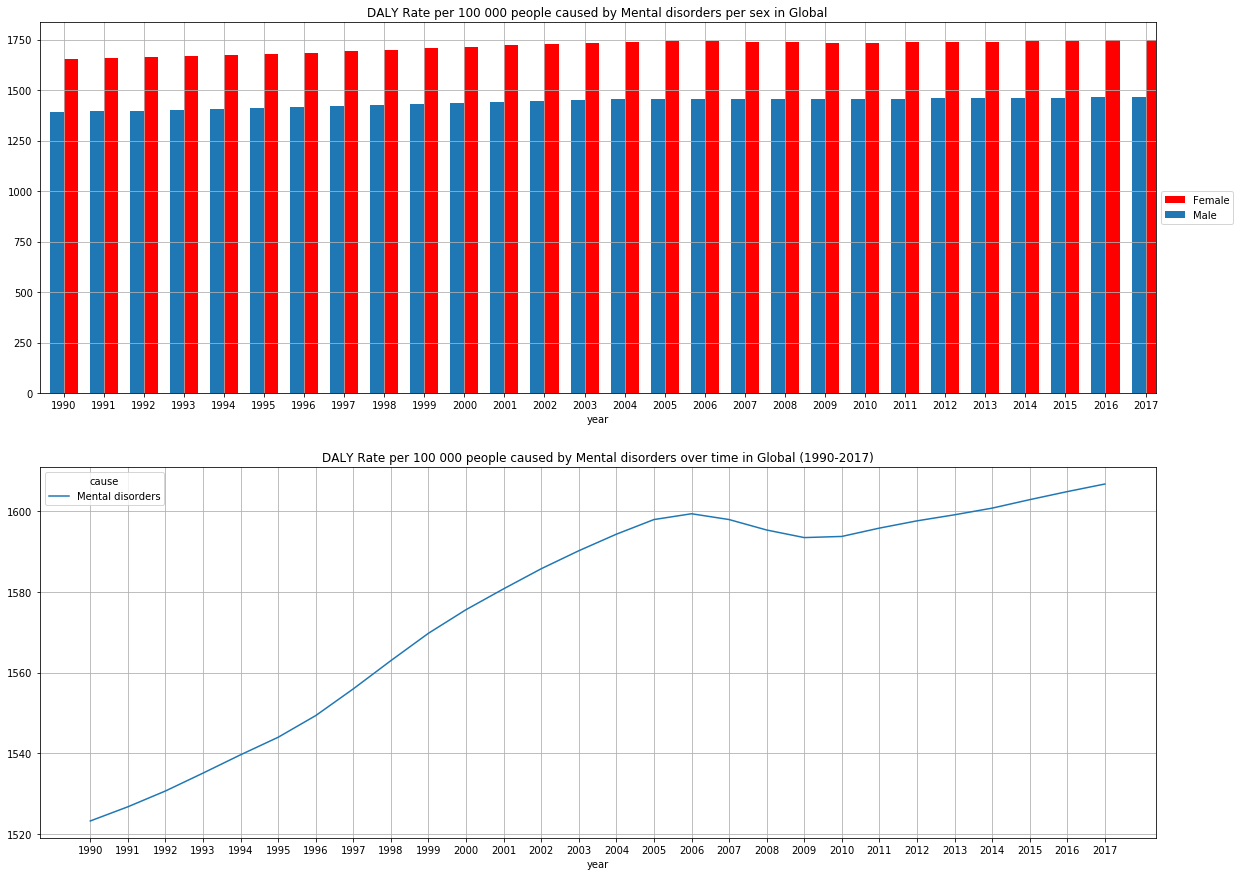

In [13]:
# Let's plot mental illness in total for China to see what it looks like
plot_DALY_per_sex_country(country='Global', location_lvl=Location.GLOBAL, cause_name=Cause.LEVEL_1, measure=Measure.RATE)

We notice that in general, mental illnesses tend to take away healthy years from more women than men (we are comparing for 100 000 people each year) - [studies](https://www.bmj.com/content/354/bmj.i5320) indeed show that women tend to have more mental issues than men. However, when looking at the trend of mental illness over years, we are suprised to find it fall near 2008, since we had the economic recession over these years. However, we can see a general increasing trend.

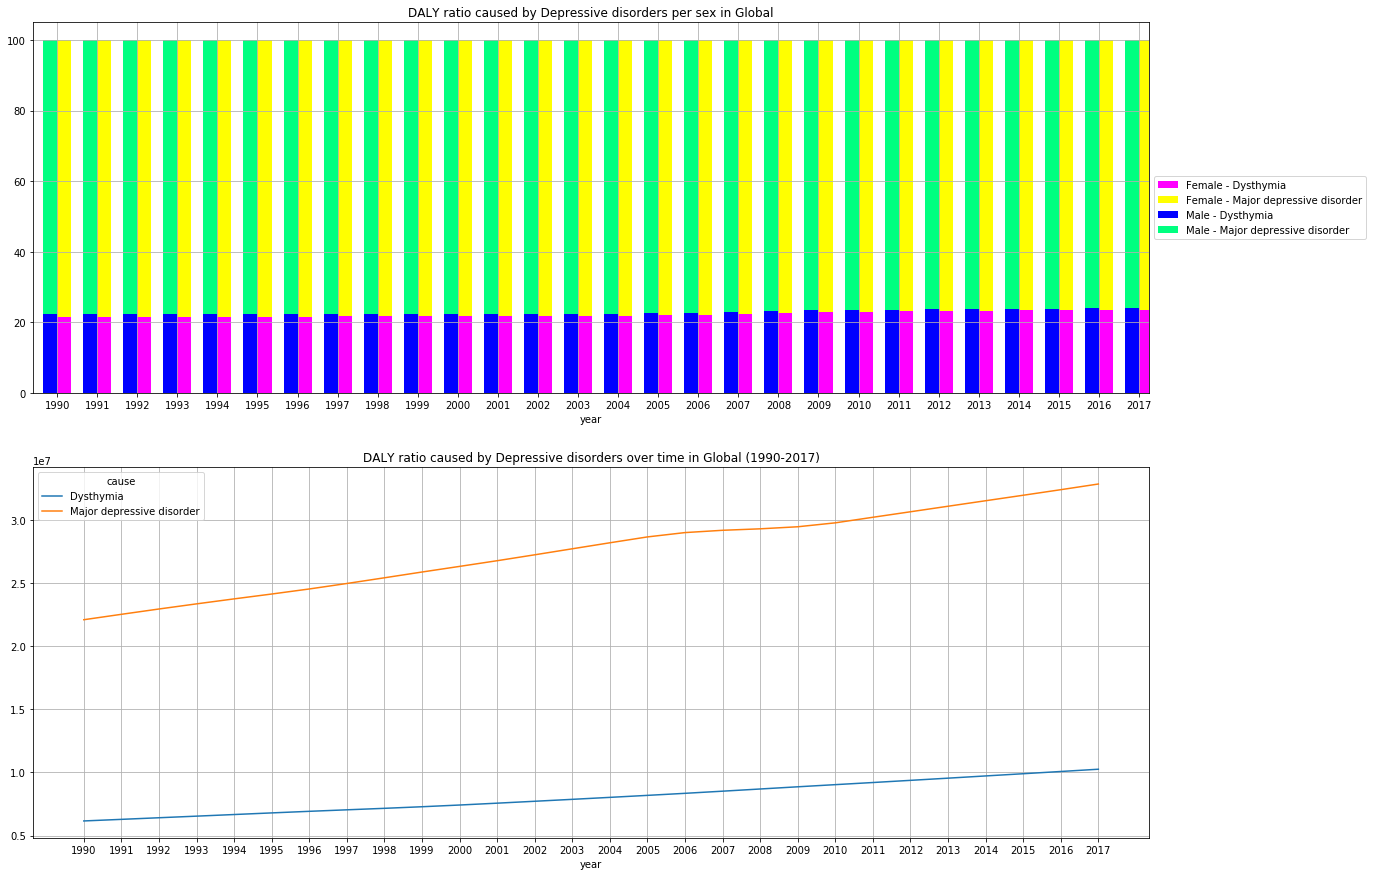

In [14]:
# Let's see what happens for a particular disease, depression, on a global scale
plot_DALY_per_sex_country(country='Global', location_lvl=Location.GLOBAL, cause_name=Cause.DEPRESSION)

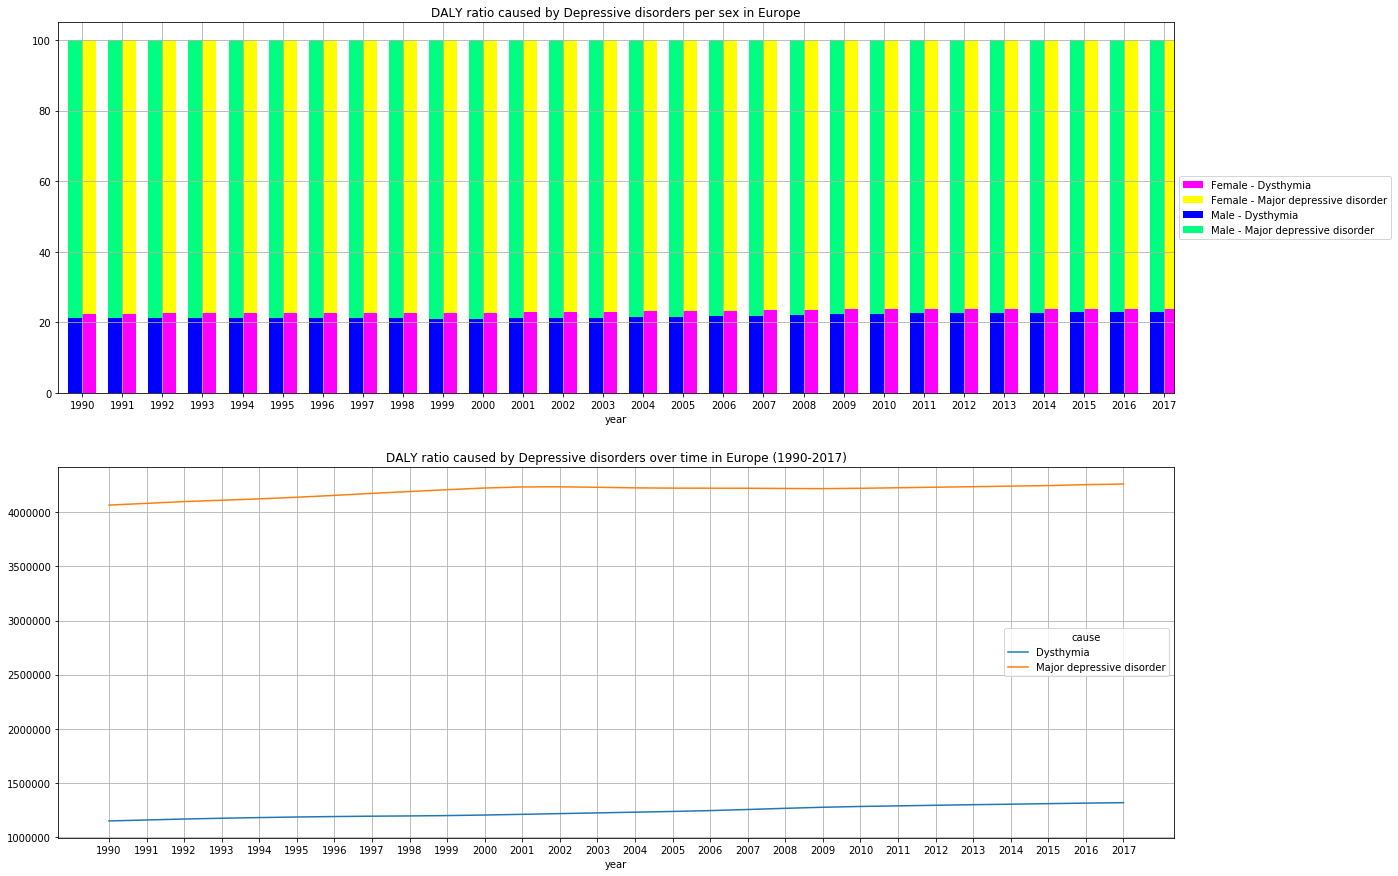

In [15]:
plot_DALY_per_sex_country(country='Europe', location_lvl=Location.CONTINENT, cause_name=Cause.DEPRESSION)

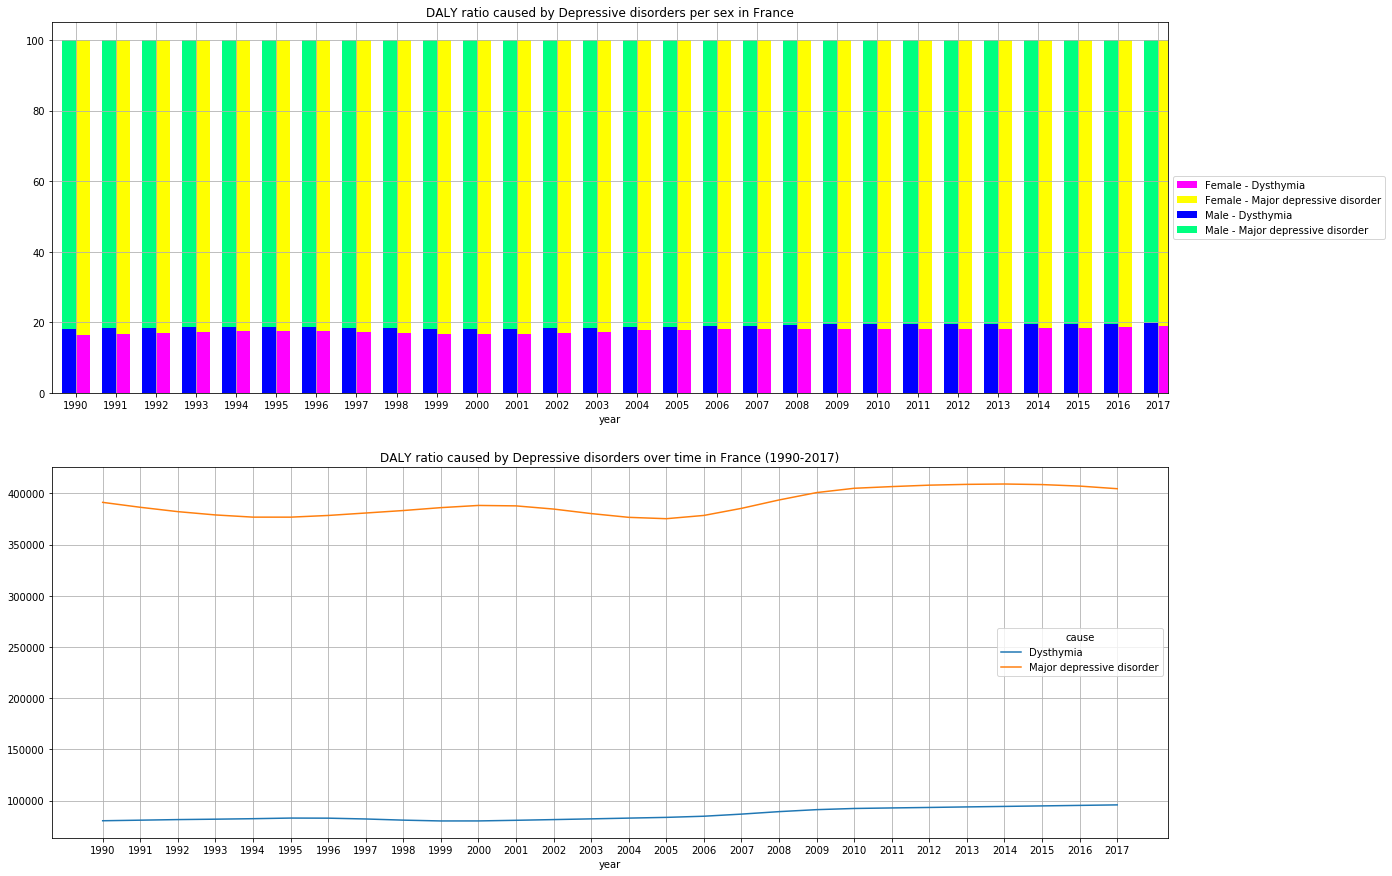

In [16]:
# Let's check for depression in particular in China
# Left colum: Male; Right column: Female
plot_DALY_per_sex_country(country='France', location_lvl=Location.COUNTRY, cause_name=Cause.DEPRESSION)

However, when we pick a particular disease, we don't see any differences globally/in a continent/ in a particular country.

#### Data per age and location over time

In [33]:
# Let's check for different ages
def plot_DALY_per_age_country(country='China', start_year=2017, end_year=2017, cause_name=Cause.LEVEL_2, measure = Measure.PERCENT, stacked=True):
    """Plot DALY measure for chosen illness per age for a specific country"""
    # Choose measure
    if measure == Measure.NUMBER:
        df_country = DALY_number_per_country[country]
        measure_name = "number"
    elif measure == Measure.RATE:
        df_country = DALY_rate_per_country[country]
        measure_name = "Rate per 100 000 people"
    elif measure == Measure.PERCENT:
        df_country = DALY_number_per_country[country]
        measure_name = "ratio"
    else:
        raise Exception("Wrong measure!")
        
    # Choose cause
    if cause_name == Cause.LEVEL_1:
        cause = level_1
    elif cause_name == Cause.LEVEL_2:
        cause = level_2
    elif cause_name == Cause.DEPRESSION:
        cause = depression
    else:
        cause = eating
    
    # Set fixed variables for sex and age
    df_country = df_country[(df_country.age != 'All Ages') & (df_country.sex == 'Both')]
    
    # Find years
    years = np.linspace(start_year, end_year, end_year - start_year + 1).astype(int)
    years_dfs = []
    
    for year in years:
        df = df_country[(df_country.year == year) & (df_country.cause.isin(cause))].groupby(['age', 'cause'])['val'].sum().unstack()
        # Normalize 
        if measure == Measure.PERCENT:
            df = df.apply(lambda x: x/x.sum() * 100, axis=1)
        years_dfs.append(df)


    df_country_over_years = df_country[(df_country.cause.isin(level_1))].groupby(['year', 'age'])['val'].sum().unstack()
        
        
    # Plot graph per years for each graph
    fig, axes = plt.subplots(figsize=(20, 10 * len(years) + 5), ncols=1, nrows=len(years) + 1)
    width = 0.5
    
    # Plot for each year
    for i, df in enumerate(years_dfs):
        df.plot.bar(stacked=stacked, ax=axes[i], grid=True, width=width, rot=0, legend=True, title="DAILY {} per age caused by {} in {} ({})".format(measure_name, cause_name.value, country, start_year + i))
        axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    df_country_over_years.plot(ax=axes[len(years)], grid=True, colormap=plt.cm.tab20, title="DALY {} caused by {} over time in {} (1990-2017)".format(measure_name, cause_name.value, country))
    # Set manually xtick for each year
    axes[len(years)].xaxis.set_ticks(df_country.year.unique())
    # Put legend outside
    axes[len(years)].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

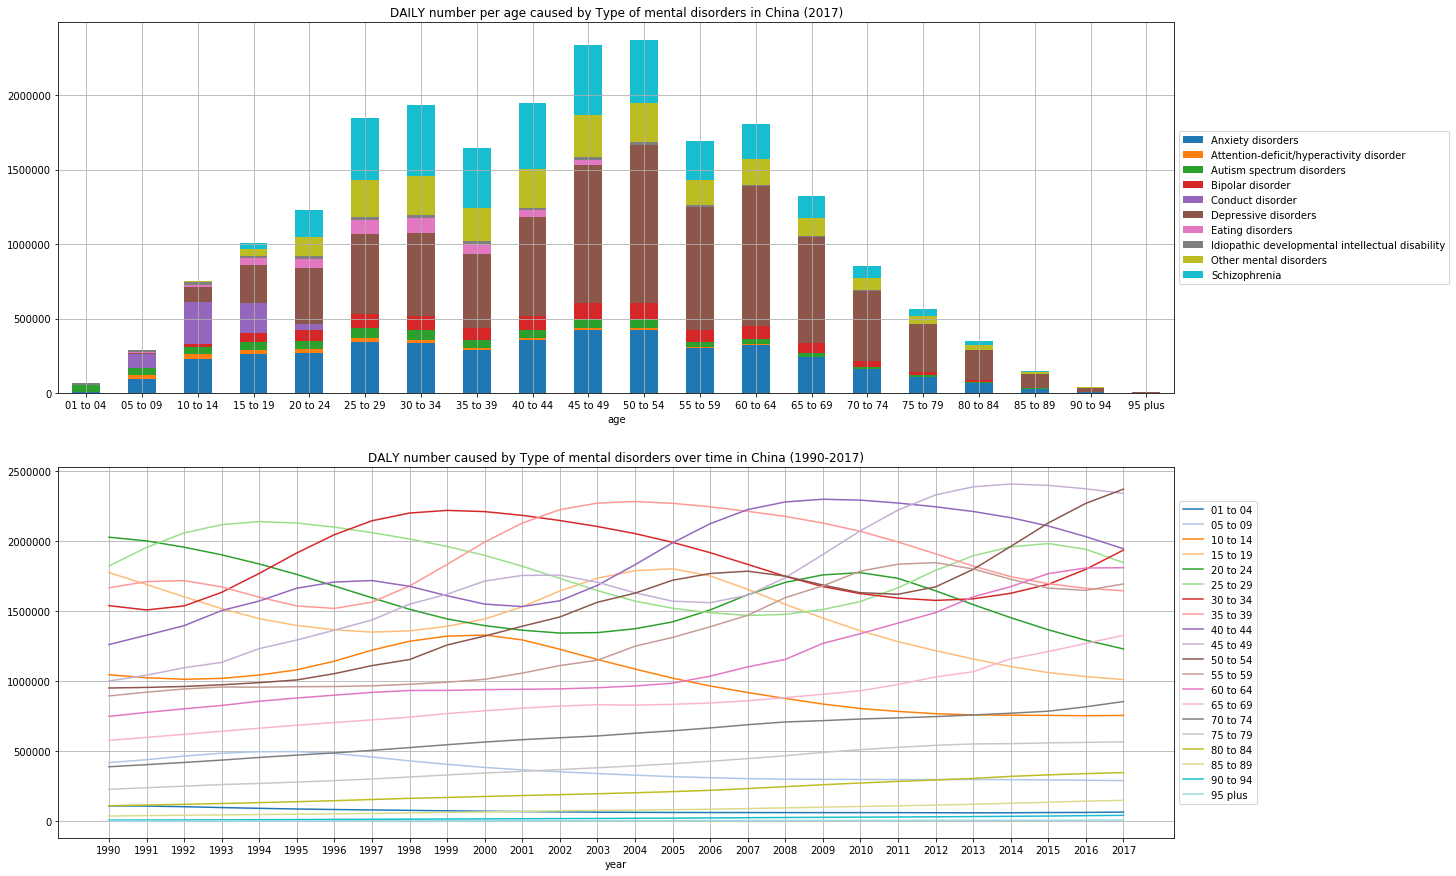

In [25]:
plot_DALY_per_age_country(country='China', cause_name=Cause.LEVEL_2, measure=Measure.NUMBER)

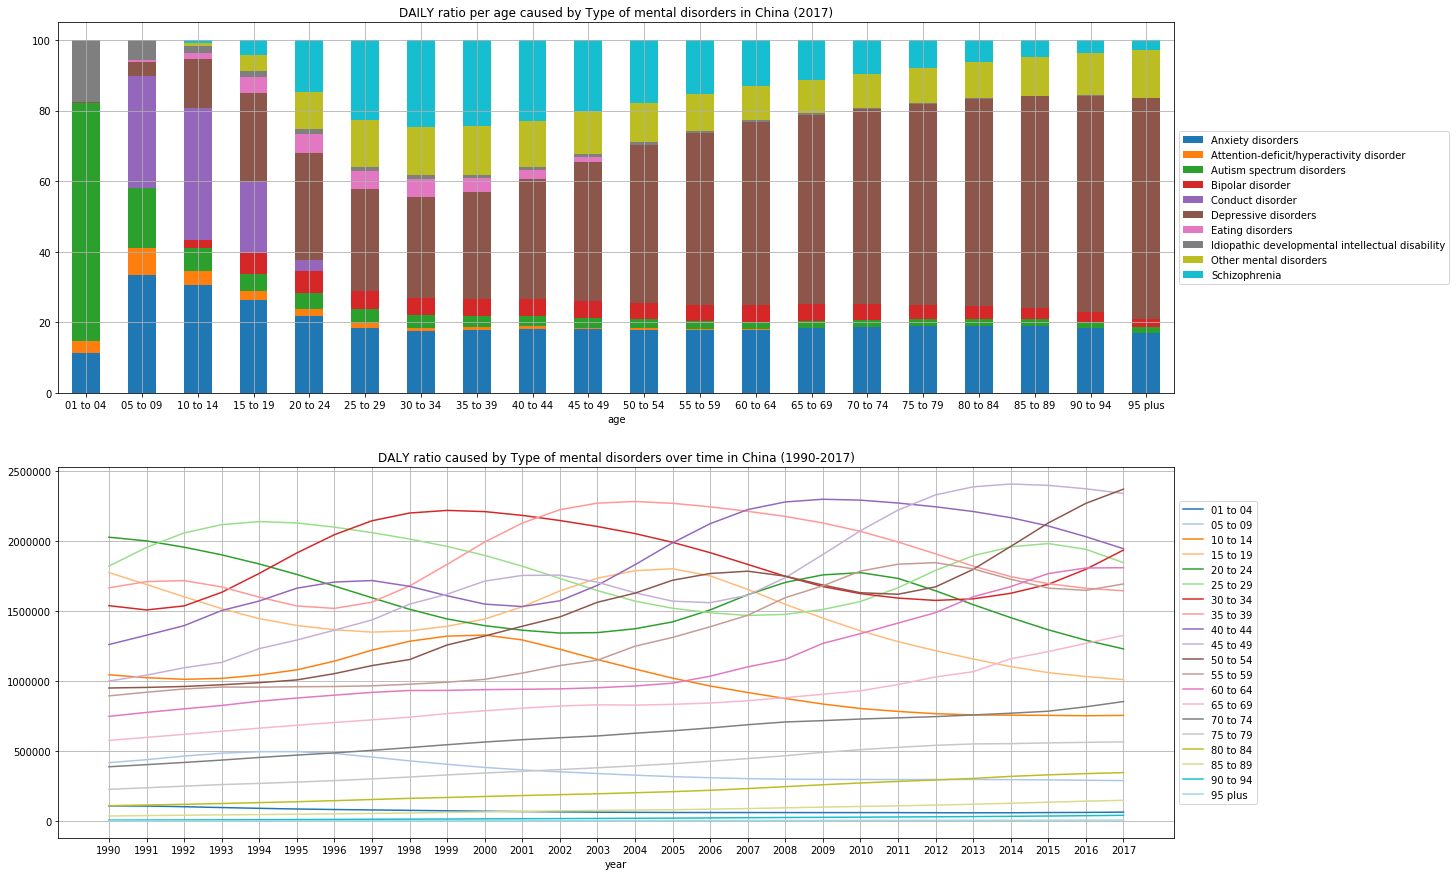

In [22]:
# Let's see the distribution DALY caused by all mental illness Globally over age in 2017
plot_DALY_per_age_country(country='China', cause_name=Cause.LEVEL_2, measure=Measure.PERCENT)

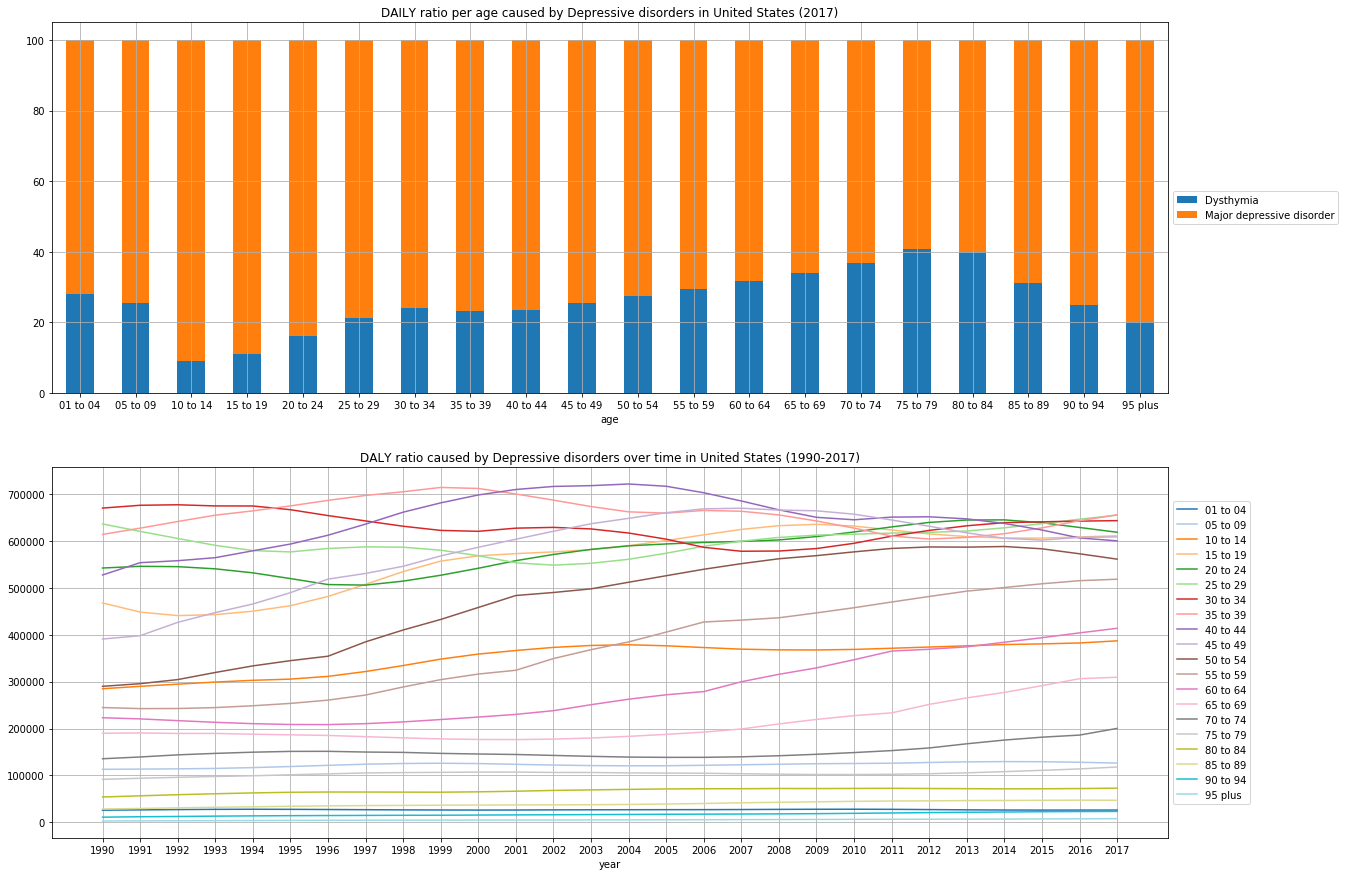

In [23]:
# Let's see the distribution DALY caused by all mental illness in China over age in 2017
plot_DALY_per_age_country(country='United States', cause_name=Cause.DEPRESSION)

As for ages, we can see that it really varies according to countries. We did not have enough time to do a deep analysis, but various sources indicates that it is due to the economic level, the culture, and the values cherished by the country. A deeper analysis will be done at step 3. 

#### DALY rank per region and per mental disorder

In [126]:
# Let's check for different ages
def plot_DALY_per_country_disorder(age="All Ages", sex="Both", location_lvl=Location.COUNTRY, year=2017, cause_name=Cause.LEVEL_2, measure = Measure.RATE, stacked=True):
    """Plot DALY measure for chosen illness per age for a specific country"""
    # Choose measure
    if measure == Measure.NUMBER or measure == Measure.PERCENT:
        df_country = DALY_number
        measure_name = "number"
    elif measure == Measure.RATE:
        df_country = DALY_rate
        measure_name = "Rate per 100 000 people"
    else:
        raise Exception("Wrong measure!")
        
    # Choose cause
    if cause_name == Cause.LEVEL_1:
        cause = level_1
    elif cause_name == Cause.LEVEL_2:
        cause = level_2
    elif cause_name == Cause.DEPRESSION:
        cause = depression
    else:
        cause = eating
        
    # Choose location level
    if location_lvl == Location.GLOBAL:
        location_name = "Globally"
        location = glob
    elif location_lvl == Location.CONTINENT:
        location_name = "By continent"
        location = continents
    elif location_lvl == Location.COUNTRY:
        location_name = "By country"
        location = countries
    
    # Set fixed variables for sex, year and age
    df_country = df_country[(df_country.age == age) & (df_country.sex == sex) & (df_country.year == year) & (df_country.location.isin(location)) & (df_country.cause.isin(cause))]

    df_country_mental_illness = df_country.groupby(['location', 'cause'])['val'].sum().unstack()
    
    fig, axes = plt.subplots(figsize=(20, 15), ncols=1, nrows=2)
    df_country_mental_illness.plot.bar(ax=axes[0], rot=0, grid=True, colormap=plt.cm.tab20, title="DALY {} of {} {} in {}".format(measure_name, cause_name.value, location_name, year))

    if measure == Measure.PERCENT:        
        measure_name = "ratio"
        df_country_mental_illness = df_country_mental_illness.apply(lambda x: x/x.sum() * 100, axis=1)
        df_country_mental_illness.plot.bar(ax=axes[1], rot=0, grid=True, stacked=True, colormap=plt.cm.tab20, title="DALY {} of {} {} in {}".format(measure_name, cause_name.value, location_name, year))
    else:
        df_country_mental_illness.plot.area(ax=axes[1], rot=0, grid=True, colormap=plt.cm.tab20, title="DALY {} of {} {} in {}".format(measure_name, cause_name.value, location_name, year))
    
    # Put legend outside
    axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
    
    return df_country_mental_illness, year

def plot_DALY_disorder_map(df, year, mental_disorder):
    # Change America to North America in order to prepare for choropleth map graphing
    df.at[1, 'location'] = 'North America'

    # Add South America where values are the same as North America
    NA_percentage = df.iloc[1, 1]
    df.loc[5] = ['South America', NA_percentage]

    #Plot the map
    world_map = folium.Map(location=[46.8182, 8.2275], tiles='cartodbpositron', zoom_start=1.5)

    world_map.choropleth(geo_data=continents_topo,
                         data=df,
                         topojson='objects.continent',
                         columns=['location', mental_disorder],
                         key_on='properties.continent',
                         fill_color='GnBu', fill_opacity=1, line_opacity=0.2,
                         legend_name='Rate of DALY per 100k peoople caused by {} per Continent in {} (%)'.format(mental_disorder, year))

    return world_map

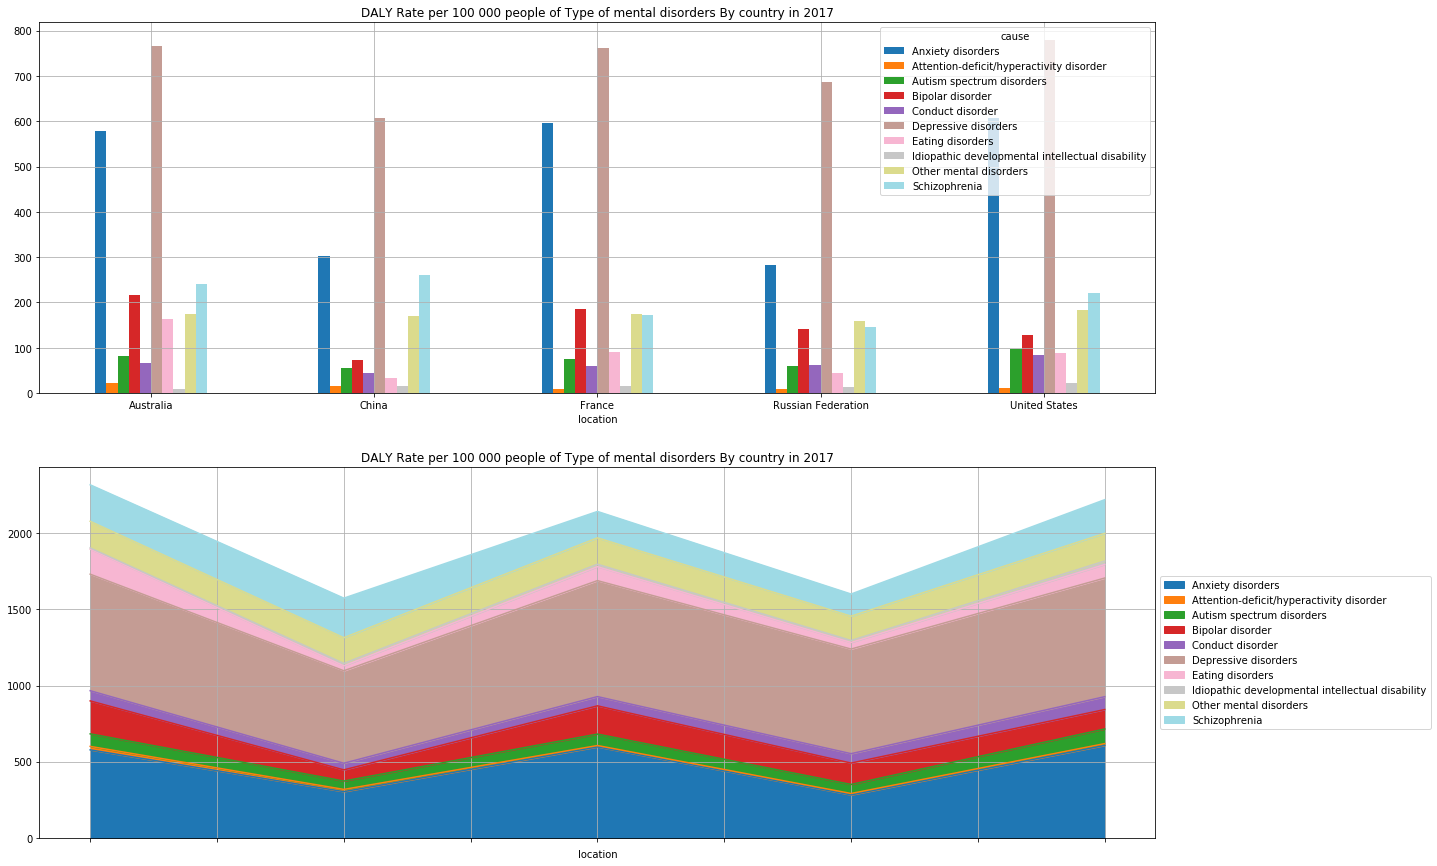

In [122]:
df_country, year_country = plot_DALY_per_country_disorder(measure = Measure.RATE)

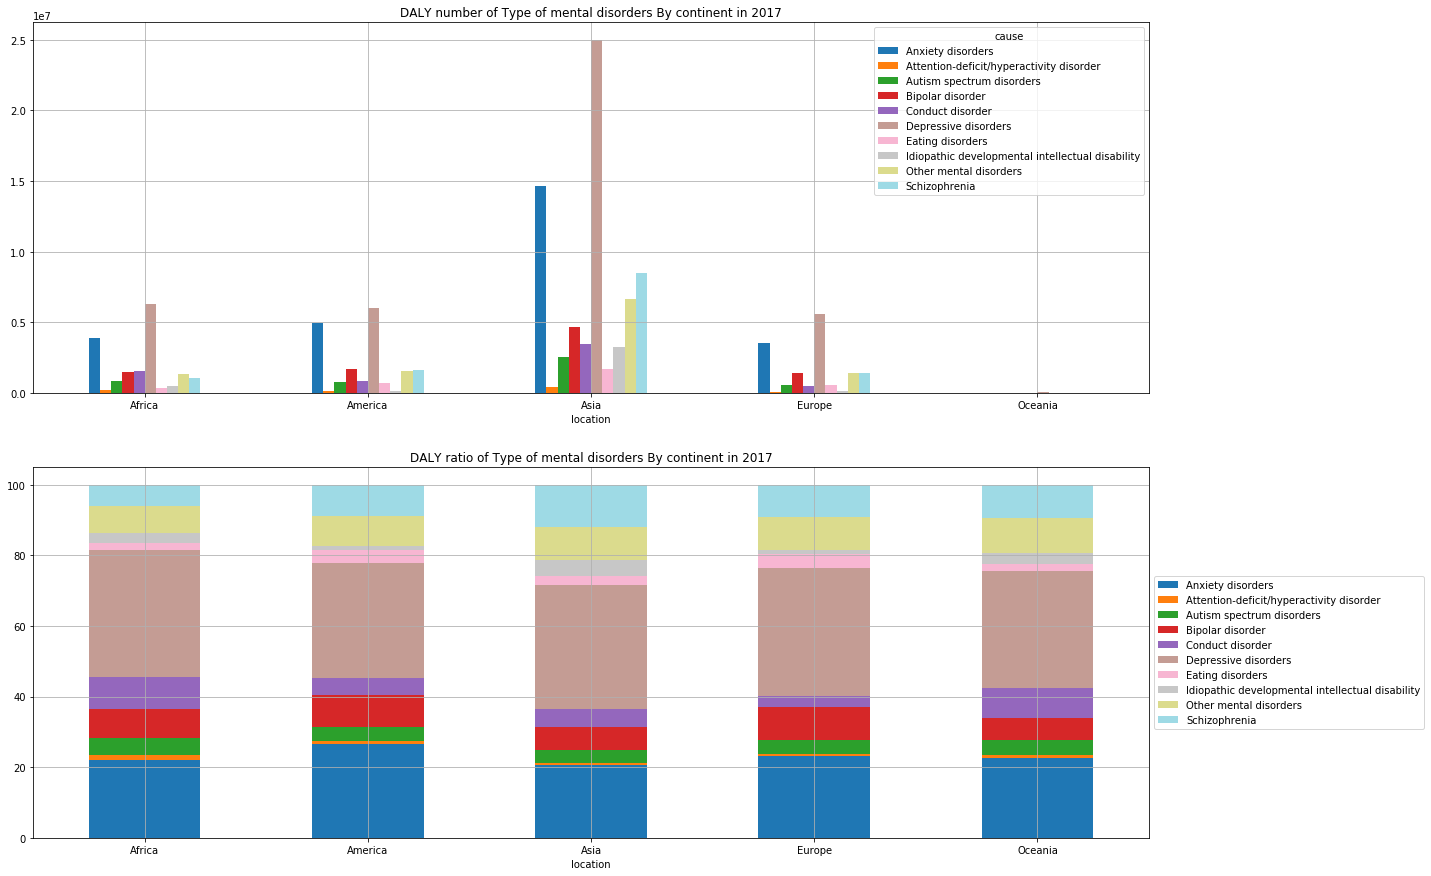

In [123]:
df_continent, year_continent = plot_DALY_per_country_disorder(measure = Measure.PERCENT, location_lvl=Location.CONTINENT)

In [124]:
disorder = 'Depressive disorders'
df_continent[disorder].reset_index().sort_values(by=disorder, ascending=False)

,location,Depressive disorders
3,Europe,36.337342
0,Africa,36.019104
2,Asia,35.293491
4,Oceania,33.123919
1,America,32.470468


In [127]:
plot_DALY_disorder_map(df_continent[disorder].reset_index(), year_continent, mental_disorder=disorder)

### Prevalence


Prevalence is a statistical concept referring to the total number of cases of a given disease in a specified population at a designated time. 

In [37]:
# Read population data to pandas dataframe
population = pd.read_csv(data_folder + 'Population_2015_2017.csv')

In [38]:
# This topojson file of the world's continents was obtained from https://github.com/deldersveld/topojson WITH PERMISSION under MIT License
continents_topo = json.load(open(r'./topojson/world-continents.json'))
# This topojson file of the wolrd's countries was obtained from https://github.com/simonepri/geo-maps (MIT liscence)
countries_topo = json.load(open(r'./topojson/countries.json'))

In [39]:
# Read prevalence data to pandas dataframe
prevalence = pd.read_csv(saving_folder + "Prevalence.csv", index_col=0, low_memory=False).dropna()
prevalence.year = prevalence.year.astype(int)
prevalence.head()

,measure,location,sex,age,cause,metric,year,val,upper,lower
PK,,,,,,,,,,
0,Prevalence,France,Male,1 to 4,Depressive disorders,Number,1990,0.0,0.0,0.0
1,Prevalence,France,Female,1 to 4,Depressive disorders,Number,1990,0.0,0.0,0.0
2,Prevalence,France,Both,1 to 4,Depressive disorders,Number,1990,0.0,0.0,0.0
3,Prevalence,France,Male,1 to 4,Depressive disorders,Rate,1990,0.0,0.0,0.0
4,Prevalence,France,Female,1 to 4,Depressive disorders,Rate,1990,0.0,0.0,0.0


There are three separate metrics to measure mental illness prevalency in the dataframe:

1. Percent - # of population with that specific disease / # of people with all diseases
2. Number - absolute number of people suffering from the disease
3. Rate

In this case, percent does not provide any useful information because we are not comparing mental illness with any other diseases. What we do want to find however, is the share of population with that disease--hence, we will compare the absolute number metric against the population data to identify the percentage of people who have that disease based on the entire population.

In [40]:
# Split the dataset according to 2 useful measures
prevalence_number = prevalence[prevalence.metric == 'Number']
prevalence_rate = prevalence[prevalence.metric == 'Rate']

#### Mental Illness Prevalence from 1990 - 2017

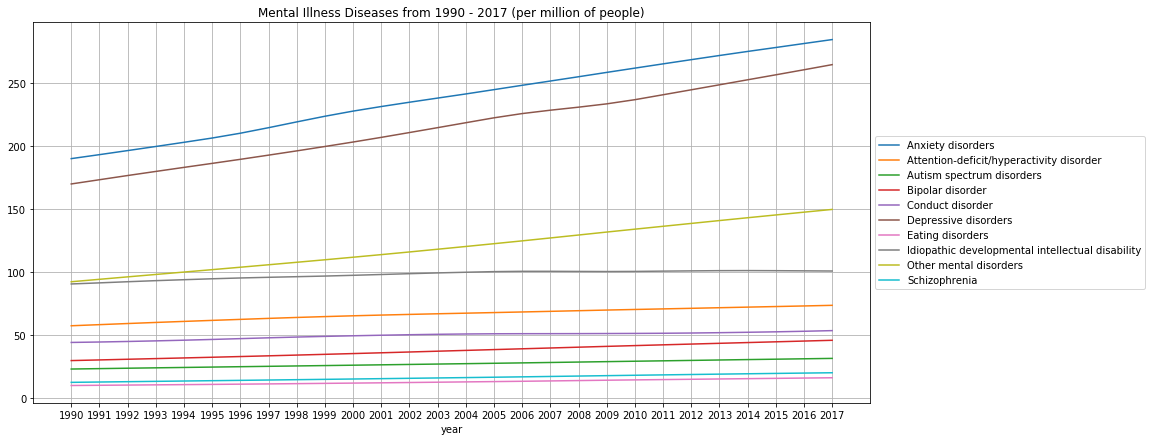

In [91]:
# Since we are comparing how prevalence of mental illness has changed over years, we decided to use absolute number as the metric.
# We filter by only including aggregated rows for all columns except year and cause_name, and we want to group by only level 2 causes.
filtered_data = prevalence_number[(prevalence_number.location == 'Global') & 
                                   (prevalence_number.cause.isin(level_2)) &
                                   (prevalence_number.sex == 'Both') &
                                   (prevalence_number.age == 'All Ages')]

fig, ax = plt.subplots(figsize=(15,7))
plot_data = filtered_data.groupby(['year', 'cause'])['val'].sum().unstack()
plot_data_million = plot_data / ONE_MILLION
plot_data_million.plot(ax=ax, grid=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_ticks(plot_data.index)
# Prevent using scientific notation
ax.ticklabel_format(useOffset=False, style='plain')
plt.title("Mental Illness Diseases from 1990 - 2017 (per million of people)")
plt.show()

In [92]:
# Numbers of people in the world who attained mental illness from 1990 - 2017 in total
pd.set_option('display.float_format', lambda x: '%.3f' % x)
filtered_data.groupby(['cause'])['val'].sum() / ONE_MILLION

cause
Anxiety disorders                                  6669.354
Attention-deficit/hyperactivity disorder           1855.165
Autism spectrum disorders                           753.334
Bipolar disorder                                   1044.729
Conduct disorder                                   1379.660
Depressive disorders                               6041.749
Eating disorders                                    350.900
Idiopathic developmental intellectual disability   2736.227
Other mental disorders                             3353.860
Schizophrenia                                       444.917
Name: val, dtype: float64

The above graph shows mental illness prevalence globally in the world, per millions of people. We observe that from 1990 - 2017, anxiety disorders and depressive disorders have shown the highest growth in terms of absolute number of people who suffer from the illness, followed by other mental disorders.

#### Mental Illness Prevalence by Continent

Here we wish to explore more in details the prevalence of mentail illness for a particular year, and we picked the most recent year existing in the dataset, 2017. Later in the third step, we plan to perform the following analysis for each year (1990-2017), and the user will be able to see the variation through time.

In [128]:
# We are interested in the most recent data, so we filter by 2017, and aggregate all other columns except location
filtered_data = prevalence_number[(prevalence_number.location.isin(continents)) & 
                                   (prevalence_number.cause.isin(level_1)) &
                                   (prevalence_number.sex == 'Both') &
                                   (prevalence_number.year == 2017) &
                                   (prevalence_number.age == 'All Ages')]

# First filter the population data to have only the information we need.
pop_filtered = population[(population.location_name.isin(continents)) & 
                           (population.sex_name == 'Both') &
                           (population.year_id == 2017) &
                           (population.age_group_name == 'All Ages')]


# Join the prevalency data with population data so we can get the prevalency as a percentage of population
filter_data_perc = pd.merge(filtered_data, pop_filtered, how='inner', left_on='location', right_on='location_name')

# Create new column as prevalency percentage of population
filter_data_perc['prevalency_percentage'] = filter_data_perc['val_x'] / filter_data_perc['val_y'] * 100

# Group data by location_name and get the mean of the 'val'
continent_mental_illness = filter_data_perc.groupby(['location'])['prevalency_percentage'].mean().reset_index()

# Change America to North America in order to prepare for choropleth map graphing
continent_mental_illness.at[1, 'location'] = 'North America'

# Add South America where values are the same as North America
NA_percentage = continent_mental_illness.iloc[1, 1]
continent_mental_illness.loc[5] = ['South America', NA_percentage]

# Change column names for easier understanding
continent_mental_illness.columns = ['continent', 'percentage']

# Sort Continents by Descending Mental Illness Prevalence
continent_mental_illness.sort_values(by=['percentage'], ascending=False)

,continent,percentage
1,North America,13.916
5,South America,13.916
3,Europe,13.576
2,Asia,12.613
0,Africa,11.502
4,Oceania,10.357


We can observe that America have the highest mental illness prevalence measured by percentage of the population, while Oceania has the least.

In [233]:
# Plot the map
world_map = folium.Map(location=[46.8182, 8.2275], tiles='cartodbpositron', zoom_start=1.5)

world_map.choropleth(geo_data=continents_topo,
                     data=continent_mental_illness,
                     topojson='objects.continent',
                     columns=['continent', 'percentage'],
                     key_on='properties.continent',
                     fill_color='GnBu', fill_opacity=1, line_opacity=0.2,
                     legend_name='Share of Population with Mental Illness per Continent in 2017 (%)')

world_map

In [132]:
# Save as HTML so it can render on Github
world_map.save('Mental_Illness_by_Continent.html')

#### Mental Illness Prevalence by Country

Let's see what happens in the same year for the countries we have selected.

In [138]:
# Only use the selcted countries
prevalence_number_country = prevalence_number[prevalence_number.location.isin(countries)]

In [174]:
# We are interested in the most recent data, so we filter by 2017, and aggregate all other columns except location_name
filtered_data = prevalence_number_country[(prevalence_number_country.cause.isin(level_1)) &
                                   (prevalence_number_country.sex == 'Both') &
                                   (prevalence_number_country.year == 2017) &
                                   (prevalence_number_country.age == 'All Ages')]

# First filter the population data to have only the information we need.
pop_filtered = population[(population.location_name.isin(countries)) &
                          (population.sex_name == 'Both') &
                          (population.year_id == 2017) &
                          (population.age_group_name == 'All Ages')]

# Join the prevalency data with population data so we can get the prevalency as a percentage of population
filter_data_perc = pd.merge(filtered_data, pop_filtered, how='left', left_on=['location'], right_on=['location_name'])

# Create new column as prevalency percentage of population
filter_data_perc['prevalency_percentage'] = filter_data_perc['val_x'] / filter_data_perc['val_y'] * 100
filter_data_perc['prevalency_percentage'] = filter_data_perc['prevalency_percentage'].fillna(0)

country_mental_illness = filter_data_perc.groupby(['location'])['prevalency_percentage'].mean().reset_index()

# Change column names for easier understanding
country_mental_illness.columns = ['country', 'percentage']

# Sort Continents by Descending Mental Illness Prevalence
country_mental_illness.sort_values(by=['percentage'], ascending=False)

# Change Russian Federation to Russia in order to prepare for choropleth map graphing
country_mental_illness.loc[(country_mental_illness['country']=='Russian Federation'), 'country'] = 'Russia'

country_mental_illness

,country,percentage
0,Australia,16.749
1,China,11.892
2,France,15.549
3,Russia,11.967
4,United States,16.415


In [257]:
country_mental_illness_dict = country_mental_illness.set_index('country')['percentage'].to_dict()

# Construct a color map customly to be able to insert gray color for not selected countries
color_scale = LinearColormap(['yellow', 'red'], vmin=int(round(min(country_mental_illness_dict.values()),-1)),
                                                         vmax=int(round(max(country_mental_illness_dict.values()),-1)))
step_color_scale = color_scale.to_step(5)
step_color_scale.caption = 'Share of Population with Mental Illness for selected countries in 2017 (%)'

def get_color(feature):
    """Function to put the not chosen countries in gray for better vizualization"""
    value = country_mental_illness_dict.get(feature['properties']['A3'])
    if value is None:
        return '#8c8c8c' # MISSING -> gray
    else:
        return color_scale(value)

country_map = folium.Map(
    location = [50, 15], 
    zoom_start = 4
)

folium.GeoJson(
    data = countries_topo,
    style_function = lambda feature: {
        'fillColor': get_color(feature),
        'fillOpacity': 0.7,
        'color' : 'white',
        'weight' : 0.5,
    }    
).add_to(country_map)

country_map.add_child(step_color_scale)

# Show map
country_map

In [258]:
# Save as HTML so it can render on Github
country_map.save('Mental_Illness_by_Country.html')

We notice that in 2017, the percentage of the population attained by mental disorders in these selected countries don't have a significant difference. This phenomena can maybe be explained by the fact that the living conditions in these countries do not vary significantly (i.e. none of them are very poor/rich compared to others).

#### Mental Illness Prevalence by Age


In [267]:
# These are the ages we will be looking at
prevalence.age = prevalence.age.replace({'5 to 9':'05 to 09', '1 to 4':'01 to 04'})
ages = [i for i in prevalence.age.unique() if i != 'All Ages']

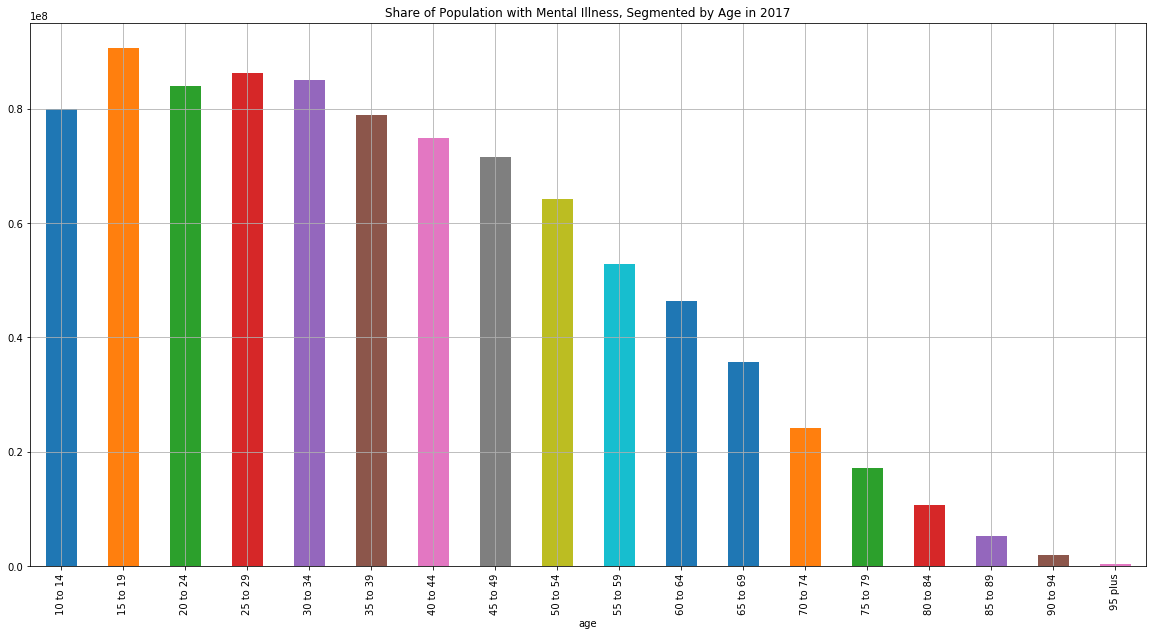

In [269]:
# aggregate all other columns except age
filtered_data = prevalence_number[(prevalence_number.location == 'Global') & 
                                   (prevalence_number.cause.isin(level_1)) &
                                   (prevalence_number.sex == 'Both') &
                                   (prevalence_number.year == 2017) &
                                   (prevalence_number.age.isin(ages))]

# filter population by aggregating all other columns except age
pop_filtered = population[(population.location_name == 'Global') &
                          (population.sex_name == 'Both') &
                          (population.year_id == 2017)]

# Join the prevalency data with population data so we can get the prevalency as a percentage of population
filter_data_perc = pd.merge(filtered_data, pop_filtered, how='inner', left_on=['age'], right_on=['age_group_name'])

# Create new column as prevalency percentage of population
filter_data_perc['prevalency_percentage'] = filter_data_perc['val_x'] / filter_data_perc['val_y'] * 100

# Filter out only the ages in ages list
# age_data = filtered_data[filtered_data.age_name.isin(ages_in_order)]
age_data = filtered_data.groupby(['age'])['val'].mean().reset_index()

# Create mapping to display graph in order of age
mapping = {day: i for i, day in enumerate(ages)}
key = age_data['age'].map(mapping)
age_data = age_data.iloc[key.argsort()]

# Plot prevalency percentage by age
age_data.plot.bar(x='age', y='val', figsize=(20,10), grid=True, legend=False,
                  title="Share of Population with Mental Illness, Segmented by Age in 2017")

Based on the above graph, mental illness peaks during the ages of 15-19, which is often when a person is in high-school, or just beginning university/college. It is possible that the stress of living away from home for the first time or high school drama could be factors that contribute to such a high mental illness percentage. The graph is left-skewed, indicating that mental illness is more prevalent during a person's early stages of life. Mental illness is lowest during 95+ and 1-4 which makes sense because people are less stressed and have fewer responsibilities as a child. 

#### Prevalence by gender

Let's look at the mental illness distribution by gender. Just as an example of analysis, we decided to analyze the distrubtion by gender globally, for all mental illnesses together, in year 2017, for a specific period of age. In step 3, we will replicate the same analysis for each continent and selected country over years.

In [401]:
def plot_prevalence_by_gender(location='Global', year=2017, cause_name=Cause.LEVEL_2, age='All Ages'):
    """Plot prevalence measure by gender"""
    # Choose mental illness level
    if cause_name == Cause.LEVEL_1:
        cause = level_1
    elif cause_name == Cause.LEVEL_2:
        cause = level_2
    elif cause_name == Cause.DEPRESSION:
        cause = depression
    else:
        cause = eating
    
    gender_datas = dict.fromkeys(location)
    
    # filter the data according to input
    gender_data = prevalence_number[(prevalence_number.location == location) & 
                                      (prevalence_number.cause.isin(cause)) &
                                      (prevalence_number.year == year) & 
                                      (prevalence_number.sex != 'Both') &
                                       (prevalence_number.age == age)]

    selected_sizes = np.zeros((2, len(cause)))
    selected_label = np.zeros(len(cause))
    
    fig, axs = plt.subplots(2, 1)
    fig.tight_layout()
    
    # Plot for each gender
    for i, gender in enumerate(gender_data.sex.unique()):
        prevalence_gender = gender_data.loc[gender_data['sex'] == gender]

        gender_gb = prevalence_gender.groupby('cause')['val'].sum().to_frame()

        selected_sizes[i] = gender_gb.val 
        selected_labels = gender_gb.index

        plot = gender_gb.val.plot.pie(y=gender_gb.index, figsize=(10, 15), ax=axs[i], legend=False, autopct='%1.0f%%', 
                            title='Prevalence of causes for mental disease among {} {} ({}, year {})'.format(gender, age, location, year))    
    
    # Rank the proportion of different types of mental disorder
    gender_df = pd.DataFrame(selected_sizes, columns=selected_labels).T
    gender_df.columns = gender_data.sex.unique()

    gender_df['Male'] = gender_df.Male / gender_df.Male.sum() * 100
    gender_df['Female'] = gender_df.Female / gender_df.Female.sum() * 100

    gender_df['Total'] = gender_df.Male + gender_df.Female

    gender_df = gender_df.sort_values(by='Total', ascending=False)
    
    gender_df = gender_df.drop(columns=['Total'], axis=1)
    return gender_df

,Male,Female
cause,,
Anxiety disorders,21.208,33.121
Depressive disorders,20.653,29.944
Other mental disorders,17.831,11.241
Idiopathic developmental intellectual disability,10.859,8.614
Attention-deficit/hyperactivity disorder,10.371,4.014
Conduct disorder,6.943,3.455
Bipolar disorder,4.383,4.395
Autism spectrum disorders,4.745,1.398
Schizophrenia,2.028,1.793


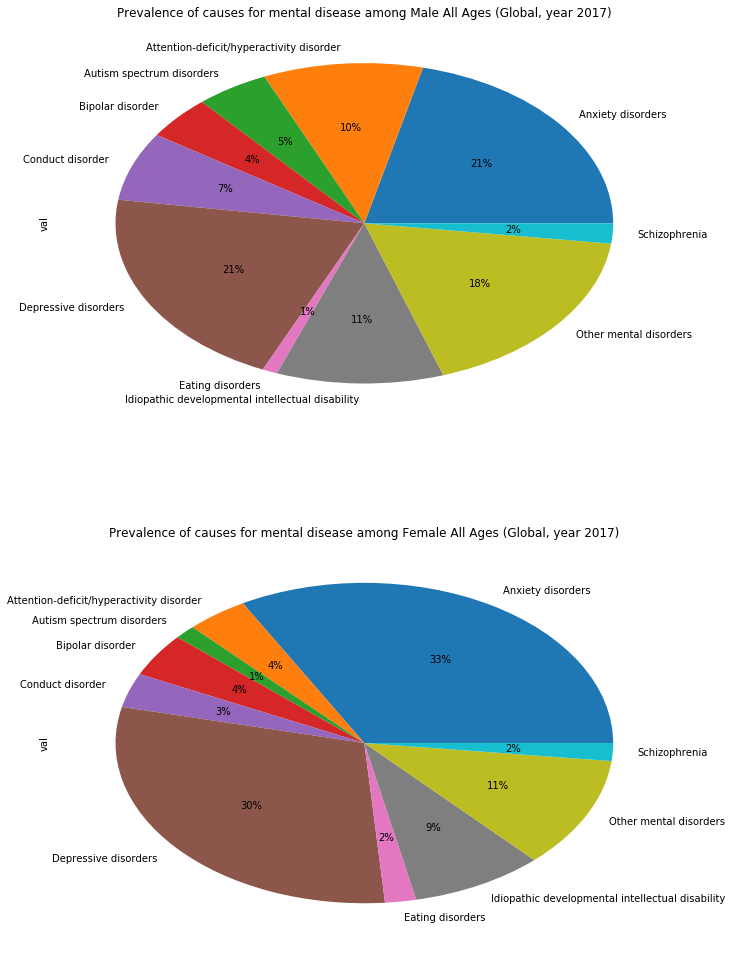

In [402]:
# Plot by gender, for year 2017, per mental disorders
plot_prevalence_by_gender()

We notice that on a global scale, in 2017, the two mental illnesses that most affected both men and women are Depressive Disorders and Anxiety disorders. The proportion in women is in both case much larger than the proportion in men. We also notice that a larger percentage of men tend to have Attention-deficit/hyperactivity disorder than women (10% vs 4%). This corresponds to the result from [this study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3101894/), where it says that "Males are generally more likely to be diagnosed with ADHD than females, with a male to female ratio of approximately 4:1 in community samples."

,Male,Female
cause,,
Anxiety disorders,23.618,36.163
Depressive disorders,22.725,32.304
Other mental disorders,21.153,12.081
Attention-deficit/hyperactivity disorder,9.439,2.892
Bipolar disorder,5.668,5.855
Conduct disorder,4.963,2.124
Autism spectrum disorders,5.640,1.343
Idiopathic developmental intellectual disability,3.467,2.615
Eating disorders,1.304,2.969


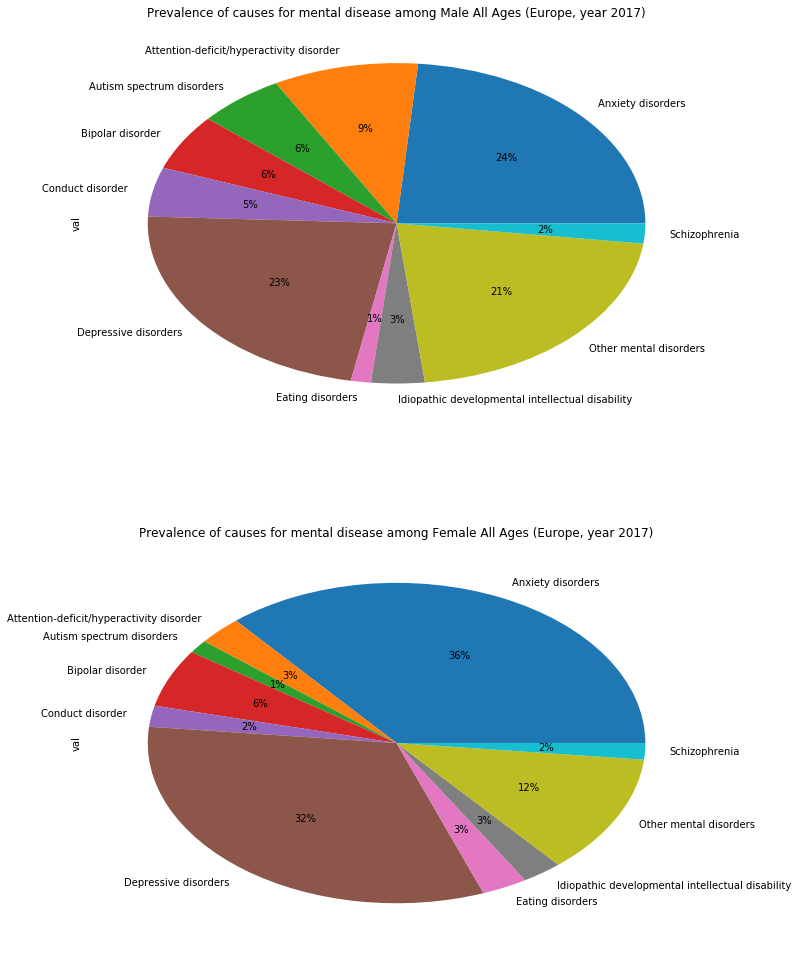

In [403]:
# Let's check in a continent
plot_prevalence_by_gender(location='Europe')

,Male,Female
cause,,
Anxiety disorders,27.268,44.108
Depressive disorders,22.395,29.514
Other mental disorders,20.240,9.723
Bipolar disorder,5.702,5.239
Attention-deficit/hyperactivity disorder,8.124,2.023
Autism spectrum disorders,5.799,1.043
Conduct disorder,4.831,1.694
Eating disorders,1.504,3.237
Idiopathic developmental intellectual disability,2.157,2.040


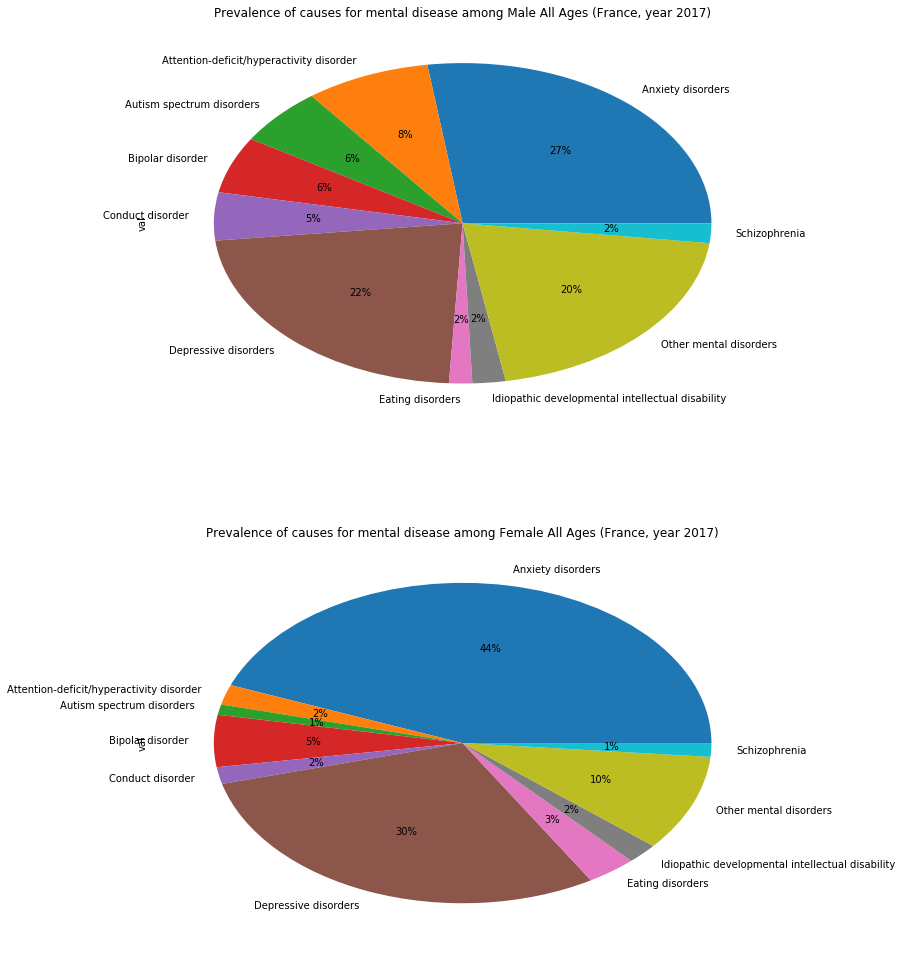

In [405]:
# Let's check in a country
plot_prevalence_by_gender(location='France')

We see that the general trend doesn't change, but there are differences based on the regions. Due to time constraints, we did not manage to do the complete analysis for each country. In step 3, we will need to do deeper researches concerning each location.